# Autotalker Data Analysis

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 22.01.2023
- **Date of Last Modification:** 02.02.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../autotalker")

In [17]:
import argparse
import os
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib import gridspec
from matplotlib.pyplot import rc_context

from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps,
                              get_unique_genes_from_gp_dict)

### 1.2 Define Parameters

In [47]:
## Dataset
dataset = "seqfish_mouse_organogenesis"
batch1 = "embryo1_z2"
batch2 = "embryo1_z5"
batch3 = "embryo2_z2"
batch4 = "embryo2_z5"
batch5 = "embryo3_z2"
batch6 = "embryo3_z5"
n_neighbors = 4
reference_removed_cell_type = "Presomitic mesoderm"

## Model
# AnnData Keys
counts_key = "log_normalized_counts" # raw counts not available
cell_type_key = "celltype_mapped_refined"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
latent_key = "autotalker_latent"
condition_key = "batch"

# Architecture
active_gp_thresh_ratio = 0.03
gene_expr_recon_dist = "nb"
n_cond_embed = 3
log_variational = False # log normalized counts as input

# Trainer
n_epochs = 40
n_epochs_all_gps = 20
lr = 0.001
query_cond_embed_lr = 0.01
lambda_edge_recon = 0.01
lambda_gene_expr_recon = 0.0033

# Benchmarking
spatial_knng_key = "autotalker_spatial_knng"
latent_knng_key = "autotalker_latent_knng"

## Others
random_seed = 42
load_timestamp = "02022023_033457" # saved model to be loaded

### 1.3 Run Notebook Setup

In [22]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

In [23]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [24]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Create Directories

In [25]:
# Define paths
figure_folder_path = f"../figures/{dataset}/analysis/{current_timestamp}"
model_artifacts_folder_path = f"../artifacts/{dataset}/analysis/{current_timestamp}"
gp_data_folder_path = "../datasets/gp_data" # gene program data
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(model_artifacts_folder_path, exist_ok=True)

## 2. Data

### 2.1 Load Data

In [26]:
adata = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_imputed.h5ad")

In [27]:
# Use log normalized counts as raw counts are not available
adata.layers["log_normalized_counts"] = adata.X

### 2.2 Prepare Data & GP Mask

#### 2.2.1 Filter Genes Based on GP Mask & HVG

In [28]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.01,
    load_from_disk=True,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path)

In [29]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=False,
    file_path=omnipath_lr_interactions_file_path)

In [30]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species="mouse",
    genes_uppercase=True)

In [31]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [32]:
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

Removing GP 'CTF1_ligand_receptor_GP' as it is a subset of GP 'CTF1_ligand_targetgenes_GP'.
Removing GP 'LEP_ligand_receptor_GP' as it is a subset of GP 'LEP_ligand_targetgenes_GP'.
Removing GP 'IL4_ligand_receptor_GP' as it is a subset of GP 'IL4_ligand_targetgenes_GP'.
Removing GP 'IL12A_ligand_receptor_GP' as it is a subset of GP 'IL12A_ligand_targetgenes_GP'.
Removing GP 'IL23A_ligand_receptor_GP' as it is a subset of GP 'IL23A_ligand_targetgenes_GP'.
Removing GP 'CSF2_ligand_receptor_GP' as it is a subset of GP 'CSF2_ligand_targetgenes_GP'.
Removing GP 'IL21_ligand_receptor_GP' as it is a subset of GP 'IL21_ligand_targetgenes_GP'.
Removing GP 'TSLP_ligand_receptor_GP' as it is a subset of GP 'TSLP_ligand_targetgenes_GP'.
Removing GP 'GH2_ligand_receptor_GP' as it is a subset of GP 'GH2_ligand_targetgenes_GP'.
Removing GP 'EGF_ligand_receptor_GP' as it is a subset of GP 'EGF_ligand_targetgenes_GP'.
Removing GP 'IL10_ligand_receptor_GP' as it is a subset of GP 'IL10_ligand_targetgen

In [33]:
# Filter genes and only keep ligand, receptor, metabolitye enzyme, metabolite sensor and 
# highly variable genes (potential target genes of nichenet)
gp_dict_genes = get_unique_genes_from_gp_dict(gp_dict=combined_new_gp_dict,
                                              retrieved_gene_entities=["sources", "targets"])

omnipath_genes = get_unique_genes_from_gp_dict(gp_dict=omnipath_gp_dict,
                                               retrieved_gene_entities=["sources", "targets"])

mebocost_genes = get_unique_genes_from_gp_dict(gp_dict=mebocost_gp_dict,
                                               retrieved_gene_entities=["sources", "targets"])

nichenet_source_genes = get_unique_genes_from_gp_dict(gp_dict=nichenet_gp_dict,
                                                      retrieved_gene_entities=["sources"])

gp_relevant_genes = list(set(omnipath_genes + mebocost_genes + nichenet_source_genes))

# Keep only highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=False)

adata.var["gp_relevant"] = adata.var.index.str.upper().isin(gp_relevant_genes)
adata.var["keep_gene"] = adata.var["gp_relevant"] | adata.var["highly_variable"]
adata = adata[:, adata.var["keep_gene"] == True]
print(f"Keeping {len(adata.var_names)} highly variable or gene program relevant genes.")
adata = adata[:, adata.var_names[adata.var_names.str.upper().isin(gp_dict_genes)].sort_values()]
print(f"Keeping {len(adata.var_names)} genes after filtering genes not in gp dict.")
adata = adata[:, (adata.X.sum(axis=0) > 0)]
print(f"Keeping {len(adata.var_names)} genes after removing genes with 0 expression.")
adata = adata.copy()

Keeping 4274 highly variable or gene program relevant genes.
Keeping 4057 genes after filtering genes not in gp dict.
Keeping 3866 genes after removing genes with 0 expression.


In [34]:
# Split adata into different batches
adata_batch1 = adata[adata.obs["batch"] == batch1].copy() # reference
adata_batch2 = adata[adata.obs["batch"] == batch2].copy() # reference
adata_batch3 = adata[adata.obs["batch"] == batch3].copy() # reference
adata_batch4 = adata[adata.obs["batch"] == batch4].copy() # reference
adata_batch5 = adata[adata.obs["batch"] == batch5].copy() # query
adata_batch6 = adata[adata.obs["batch"] == batch6].copy() # query

adata_batch_list = [adata_batch1,
                    adata_batch2,
                    adata_batch3,
                    adata_batch4,
                    adata_batch5,
                    adata_batch6]

#### 2.2.2 Remove Selected Cell Type from Reference for Recovery by Query

In [35]:
# Artificially remove cell type from reference for recovery by query
for i in range(len(adata_batch_list[:-2])):
    adata_batch_list[i] = adata_batch_list[i][adata_batch_list[i].obs["celltype_mapped_refined"] != reference_removed_cell_type]

In [36]:
for i in range(len(adata_batch_list)):
    adata_batch_list[i].obs["query_specific_cell_type"] = "Cell type present in reference"
    adata_batch_list[i].obs.loc[adata_batch_list[i].obs[cell_type_key] == reference_removed_cell_type, "query_specific_cell_type"] = reference_removed_cell_type

Using dataset seqfish_mouse_organogenesis_imputed.
Number of nodes (cells): 52568
Number of node features (genes): 3866


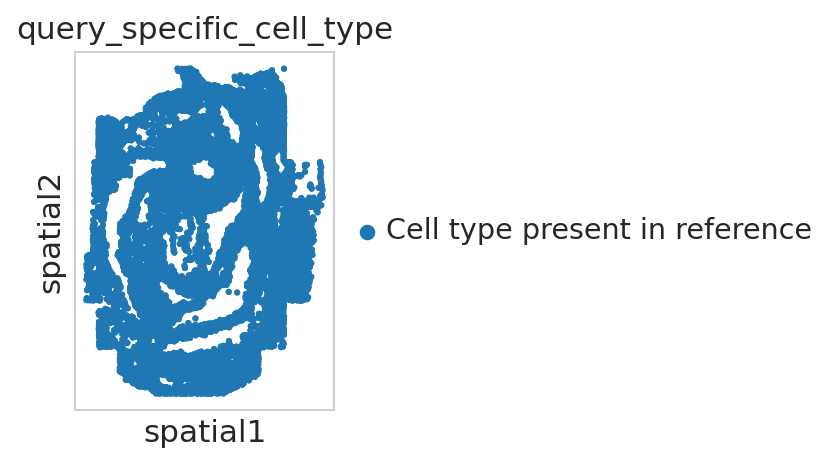

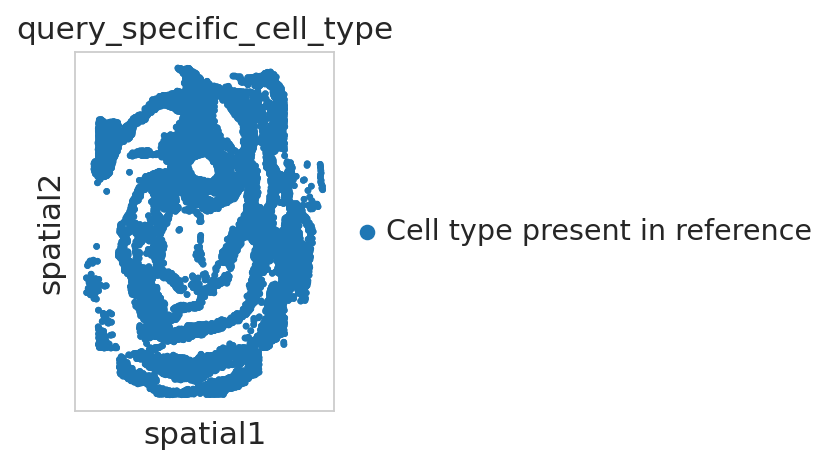

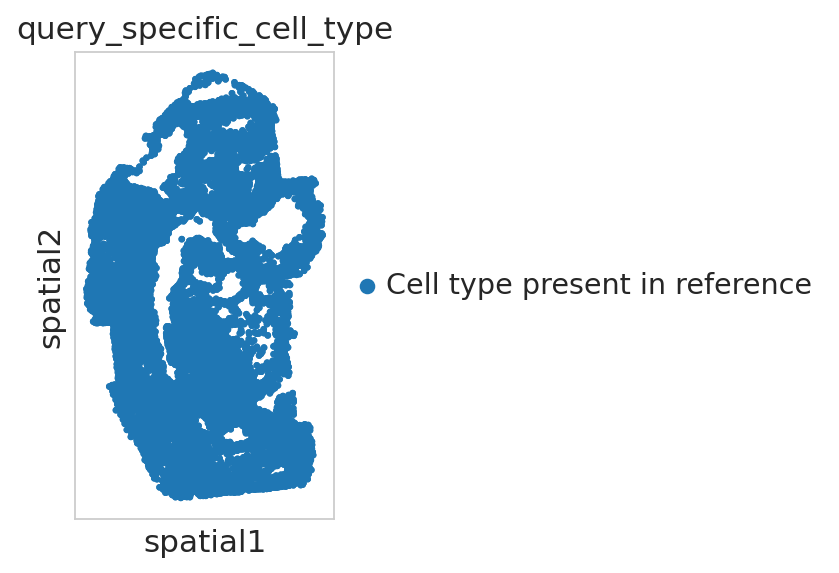

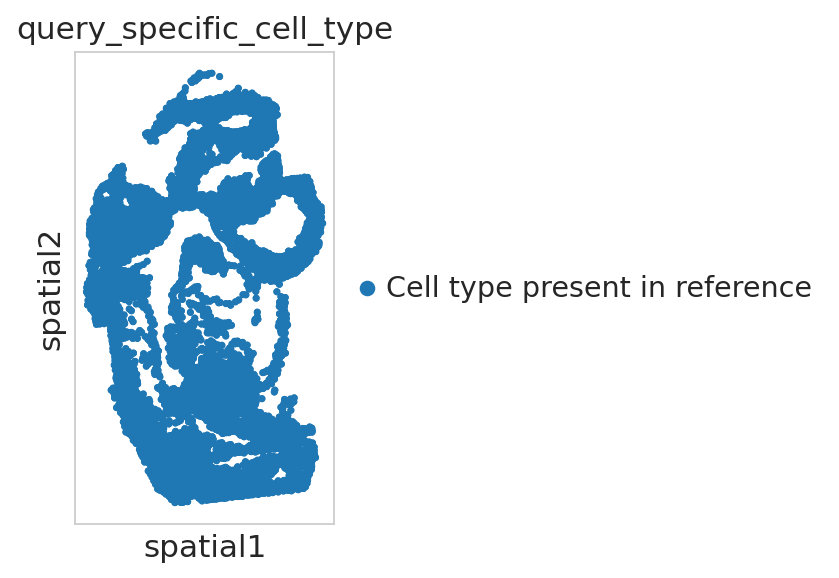

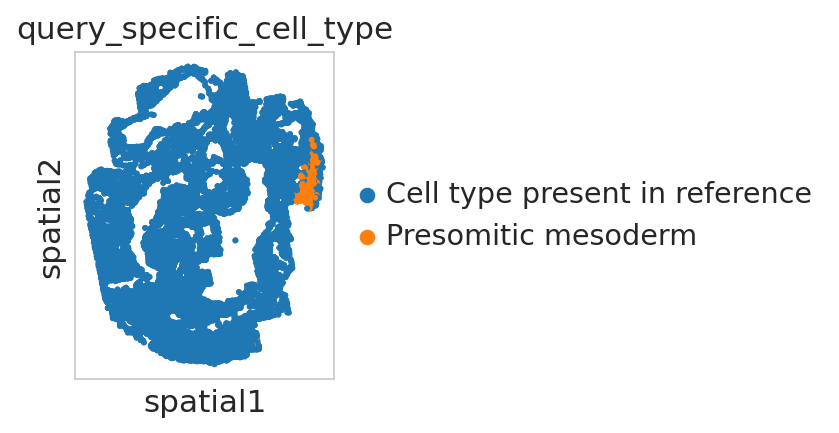

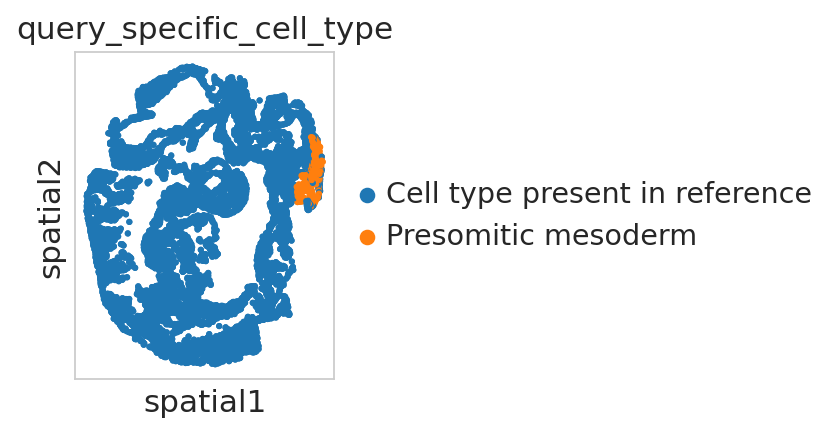

In [37]:
print(f"Using dataset {dataset}_imputed.")
print(f"Number of nodes (cells): {adata.X.shape[0]}")
print(f"Number of node features (genes): {adata.X.shape[1]}")

for adata_batch in adata_batch_list:
    # Visualize cell-level annotated data in spatial space
    sq.pl.spatial_scatter(adata_batch, color="query_specific_cell_type", shape=None, figsize=(5, 5))

### 2.3 Compute Spatial Neighbor Graphs

In [38]:
for i in range(len(adata_batch_list)):
    # Compute (separate) spatial neighborhood
    sq.gr.spatial_neighbors(adata_batch_list[i],
                            coord_type="generic",
                            spatial_key=spatial_key,
                            n_neighs=n_neighbors)
    # Make adjacency matrix symmetric
    adata_batch_list[i].obsp["spatial_connectivities"] = adata_batch_list[i].obsp["spatial_connectivities"].maximum(
        adata_batch_list[i].obsp["spatial_connectivities"].T)

### 2.5 Combine Data

In [42]:
adata_reference_query = ad.concat(adata_batch_list, join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch1 = sp.csr_matrix((adata_batch_list[0].shape[0],
                                                 (adata_batch_list[1].shape[0] +
                                                  adata_batch_list[2].shape[0] +
                                                  adata_batch_list[3].shape[0] +
                                                  adata_batch_list[4].shape[0] +
                                                  adata_batch_list[5].shape[0])))
connectivities_extension_batch2_before = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                        adata_batch_list[0].shape[0]))
connectivities_extension_batch2_after = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                       (adata_batch_list[2].shape[0] +
                                                        adata_batch_list[3].shape[0] +
                                                        adata_batch_list[4].shape[0] +
                                                        adata_batch_list[5].shape[0])))
connectivities_extension_batch3_before = sp.csr_matrix((adata_batch_list[2].shape[0],
                                                        (adata_batch_list[0].shape[0] +
                                                         adata_batch_list[1].shape[0])))
connectivities_extension_batch3_after = sp.csr_matrix((adata_batch_list[2].shape[0],
                                                       (adata_batch_list[3].shape[0] +
                                                        adata_batch_list[4].shape[0] +
                                                        adata_batch_list[5].shape[0])))
connectivities_extension_batch4_before = sp.csr_matrix((adata_batch_list[3].shape[0],
                                                        (adata_batch_list[0].shape[0] +
                                                         adata_batch_list[1].shape[0] +
                                                         adata_batch_list[2].shape[0])))
connectivities_extension_batch4_after = sp.csr_matrix((adata_batch_list[3].shape[0],
                                                       (adata_batch_list[4].shape[0] +
                                                        adata_batch_list[5].shape[0])))
connectivities_extension_batch5_before = sp.csr_matrix((adata_batch_list[4].shape[0],
                                                        (adata_batch_list[0].shape[0] +
                                                         adata_batch_list[1].shape[0] +
                                                         adata_batch_list[2].shape[0] +
                                                         adata_batch_list[3].shape[0])))
connectivities_extension_batch5_after = sp.csr_matrix((adata_batch_list[4].shape[0],
                                                       adata_batch_list[5].shape[0]))
connectivities_extension_batch6 = sp.csr_matrix((adata_batch_list[5].shape[0],
                                                 (adata_batch_list[0].shape[0] +
                                                  adata_batch_list[1].shape[0] +
                                                  adata_batch_list[2].shape[0] +
                                                  adata_batch_list[3].shape[0] +
                                                  adata_batch_list[4].shape[0])))

connectivities_batch1 = sp.hstack((adata_batch_list[0].obsp["spatial_connectivities"],
                                   connectivities_extension_batch1))
connectivities_batch2 = sp.hstack((connectivities_extension_batch2_before,
                                   adata_batch_list[1].obsp["spatial_connectivities"],
                                   connectivities_extension_batch2_after))
connectivities_batch3 = sp.hstack((connectivities_extension_batch3_before,
                                   adata_batch_list[2].obsp["spatial_connectivities"],
                                   connectivities_extension_batch3_after))
connectivities_batch4 = sp.hstack((connectivities_extension_batch4_before,
                                   adata_batch_list[3].obsp["spatial_connectivities"],
                                   connectivities_extension_batch4_after))
connectivities_batch5 = sp.hstack((connectivities_extension_batch5_before,
                                   adata_batch_list[4].obsp["spatial_connectivities"],
                                   connectivities_extension_batch5_after))
connectivities_batch6 = sp.hstack((connectivities_extension_batch6,
                                   adata_batch_list[5].obsp["spatial_connectivities"]))

connectivities = sp.vstack((connectivities_batch1,
                            connectivities_batch2,
                            connectivities_batch3,
                            connectivities_batch4,
                            connectivities_batch5,
                            connectivities_batch6))

adata_reference_query.obsp["spatial_connectivities"] = connectivities

In [43]:
reference_batches = adata_reference.obs["batch"].unique().tolist()
query_batches = adata_query.obs["batch"].unique().tolist()
adata_reference_query.obs["mapping_entity"] = None
adata_reference_query.obs.loc[adata_reference_query.obs["batch"].isin(reference_batches), "mapping_entity"] = "reference"
adata_reference_query.obs.loc[adata_reference_query.obs["batch"].isin(query_batches), "mapping_entity"] = "query"

### 2.6 Add GP Mask to Data

In [45]:
# Add the gene program dictionary as binary masks to the adata for model training
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata_reference_query,
    genes_uppercase=True,
    gp_targets_mask_key="autotalker_gp_targets",
    gp_sources_mask_key="autotalker_gp_sources",
    gp_names_key="autotalker_gp_names",
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None,
    filter_genes_not_in_masks=False)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata_reference_query.uns["autotalker_gp_names"])

# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata_reference_query.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(list(adata_reference_query.uns['autotalker_gp_names']), 5)}.")
print(f"Number of gene program target genes: {adata_reference_query.varm['autotalker_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata_reference_query.varm['autotalker_gp_sources'].sum()}.")

Number of gene programs with probed genes: 1521.
Example gene programs: ['IL13_ligand_targetgenes_GP', 'LY96_ligand_receptor_GP', 'FZD8_ligand_receptor_GP', 'CEACAM6_ligand_receptor_GP', 'NECTIN2_ligand_receptor_GP'].
Number of gene program target genes: 52982.
Number of gene program source genes: 3374.


## 4. Analysis

### 4.1 Load Model

In [48]:
# Load trained model
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path
    
# Load trained model    
model = Autotalker.load(dir_path=f"{model_artifacts_load_folder_path}/reference_query",
                        adata=adata_reference_query,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> False
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 3866, n_cond_embed_input: 3, n_hidden: 1521, n_latent: 1521, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 1521, dropout_rate: 0.0
3
MASKED GENE EXPRESSION DECODER -> n_input: 1521, n_cond_embed_input: 3, n_addon_input: 0, n_output: 7732


### Inspect Gene Programs

In [49]:
# Check number of active gene programs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 1521.
Number of active gene programs: 207.


In [50]:
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"]]

gp_name  gp_active  \
9                          CXCL12_ligand_targetgenes_GP       True   
28                            IL6_ligand_targetgenes_GP       True   
34                           CTF1_ligand_targetgenes_GP       True   
36                            LEP_ligand_targetgenes_GP       True   
38                           IL13_ligand_targetgenes_GP       True   
...                                                 ...        ...   
1498                    ADP_metabolite_enzyme_sensor_GP       True   
1499                Retinal_metabolite_enzyme_sensor_GP       True   
1504              Phosphate_metabolite_enzyme_sensor_GP       True   
1508  all-trans-Retinoic acid_metabolite_enzyme_sens...       True   
1512      Hydrogen peroxide_metabolite_enzyme_sensor_GP       True   

                                        gp_source_genes  \
9                                              [Cxcl12]   
28                                                [Il6]   
34                                               [Ctf1]   
36                                                   []   
38                                                   []   
...                                                 ...   
1498  [Nme5, Hk3, Ckb, Papss2, Hkdc1, Entpd8, Sphk1,...   
1499  [Aldh1a2, Adh4, Adh1, Adh7, Rdh10, Aldh1a1, Al...   
1504  [Pgam2, Ppm1j, Ptprr, Pygm, Atp13a4, Inpp5j, C...   
1508  [Cyp4a31, Ugt2b5, Ugt2b1, Ugt2a3, Ugt2b36, Ugt...   
1512  [Gpx2, Ddo, Epx, Aox1, Hao2, Hao1, Sod3, Pnpo,...   

                                        gp_target_genes  \
9     [Il10, Mtnr1a, Pgr, Vav1, Egf, Ifng, Ceacam1, ...   
28    [Cxcl13, Saa2, Tnfrsf11b, Orm1, Tshr, Hp, Dcn,...   
34    [Wnt1, Rgn, Insrr, Zic1, Irx4, Phlda2, Pipox, ...   
36    [Gria1, Cd8a, Hamp, Ccl5, Me1, Cartpt, Faah, T...   
38    [Hsd3b1, Aldh1a2, Itgax, Mmp12, Scgb1a1, Alox5...   
...                                                 ...   
1498                            [P2ry1, P2ry12, P2ry13]   
1499        [Rxrg, Stra6, Rarb, Rxra, Rara, Rarg, Rxrb]   
1504                                          [Slc20a2]   
1508                           [Rxrg, Rxra, Rxrb, Rara]   
1512                                            [Trpm2]   

                                gp_source_genes_weights  \
9                                              [1.3543]   
28                                            [-0.1666]   
34                                            [-0.2667]   
36                                                   []   
38                                                   []   
...                                                 ...   
1498  [-1.3516, -1.1877, -1.1815, 1.0005, -0.9755, 0...   
1499  [1.7855, 1.3847, 1.1338, -0.8345, 0.7051, -0.5...   
1504  [-4.4489, -3.6648, -3.0817, -2.986, -2.7075, -...   
1508  [-0.2397, -0.1861, -0.1313, -0.1014, -0.0982, ...   
1512  [-3.1973, -2.0032, -1.0535, -0.8926, -0.7327, ...   

                                gp_target_genes_weights  
9     [0.3676, 0.3451, 0.34, -0.32, -0.1722, -0.1658...  
28    [-0.8694, -0.746, -0.4532, -0.4266, -0.4066, -...  
34    [2.5617, -2.404, 1.9958, 1.6223, 1.3599, -1.26...  
36    [-0.9123, -0.842, 0.7097, 0.6837, -0.6654, 0.6...  
38    [-1.0833, 1.0776, -1.044, -0.9092, 0.8279, -0....  
...                                                 ...  
1498                           [0.9975, 0.8227, 0.2703]  
1499  [-0.3832, 0.3454, 0.104, -0.1004, 0.0428, -0.0...  
1504                                           [0.0817]  
1508                 [0.0096, -0.0028, 0.0012, -0.0004]  
1512                                          [-0.4118]  

[207 rows x 6 columns]

In [54]:
model.adata.obsm[latent_key] = model.get_latent_representation(
    adata=model.adata,
    counts_key=counts_key,
    condition_key=condition_key)

In [55]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key, key_added=latent_key)
sc.tl.umap(model.adata, neighbors_key=latent_key)

### 4.1 Cell Types in Physical and Latent Space

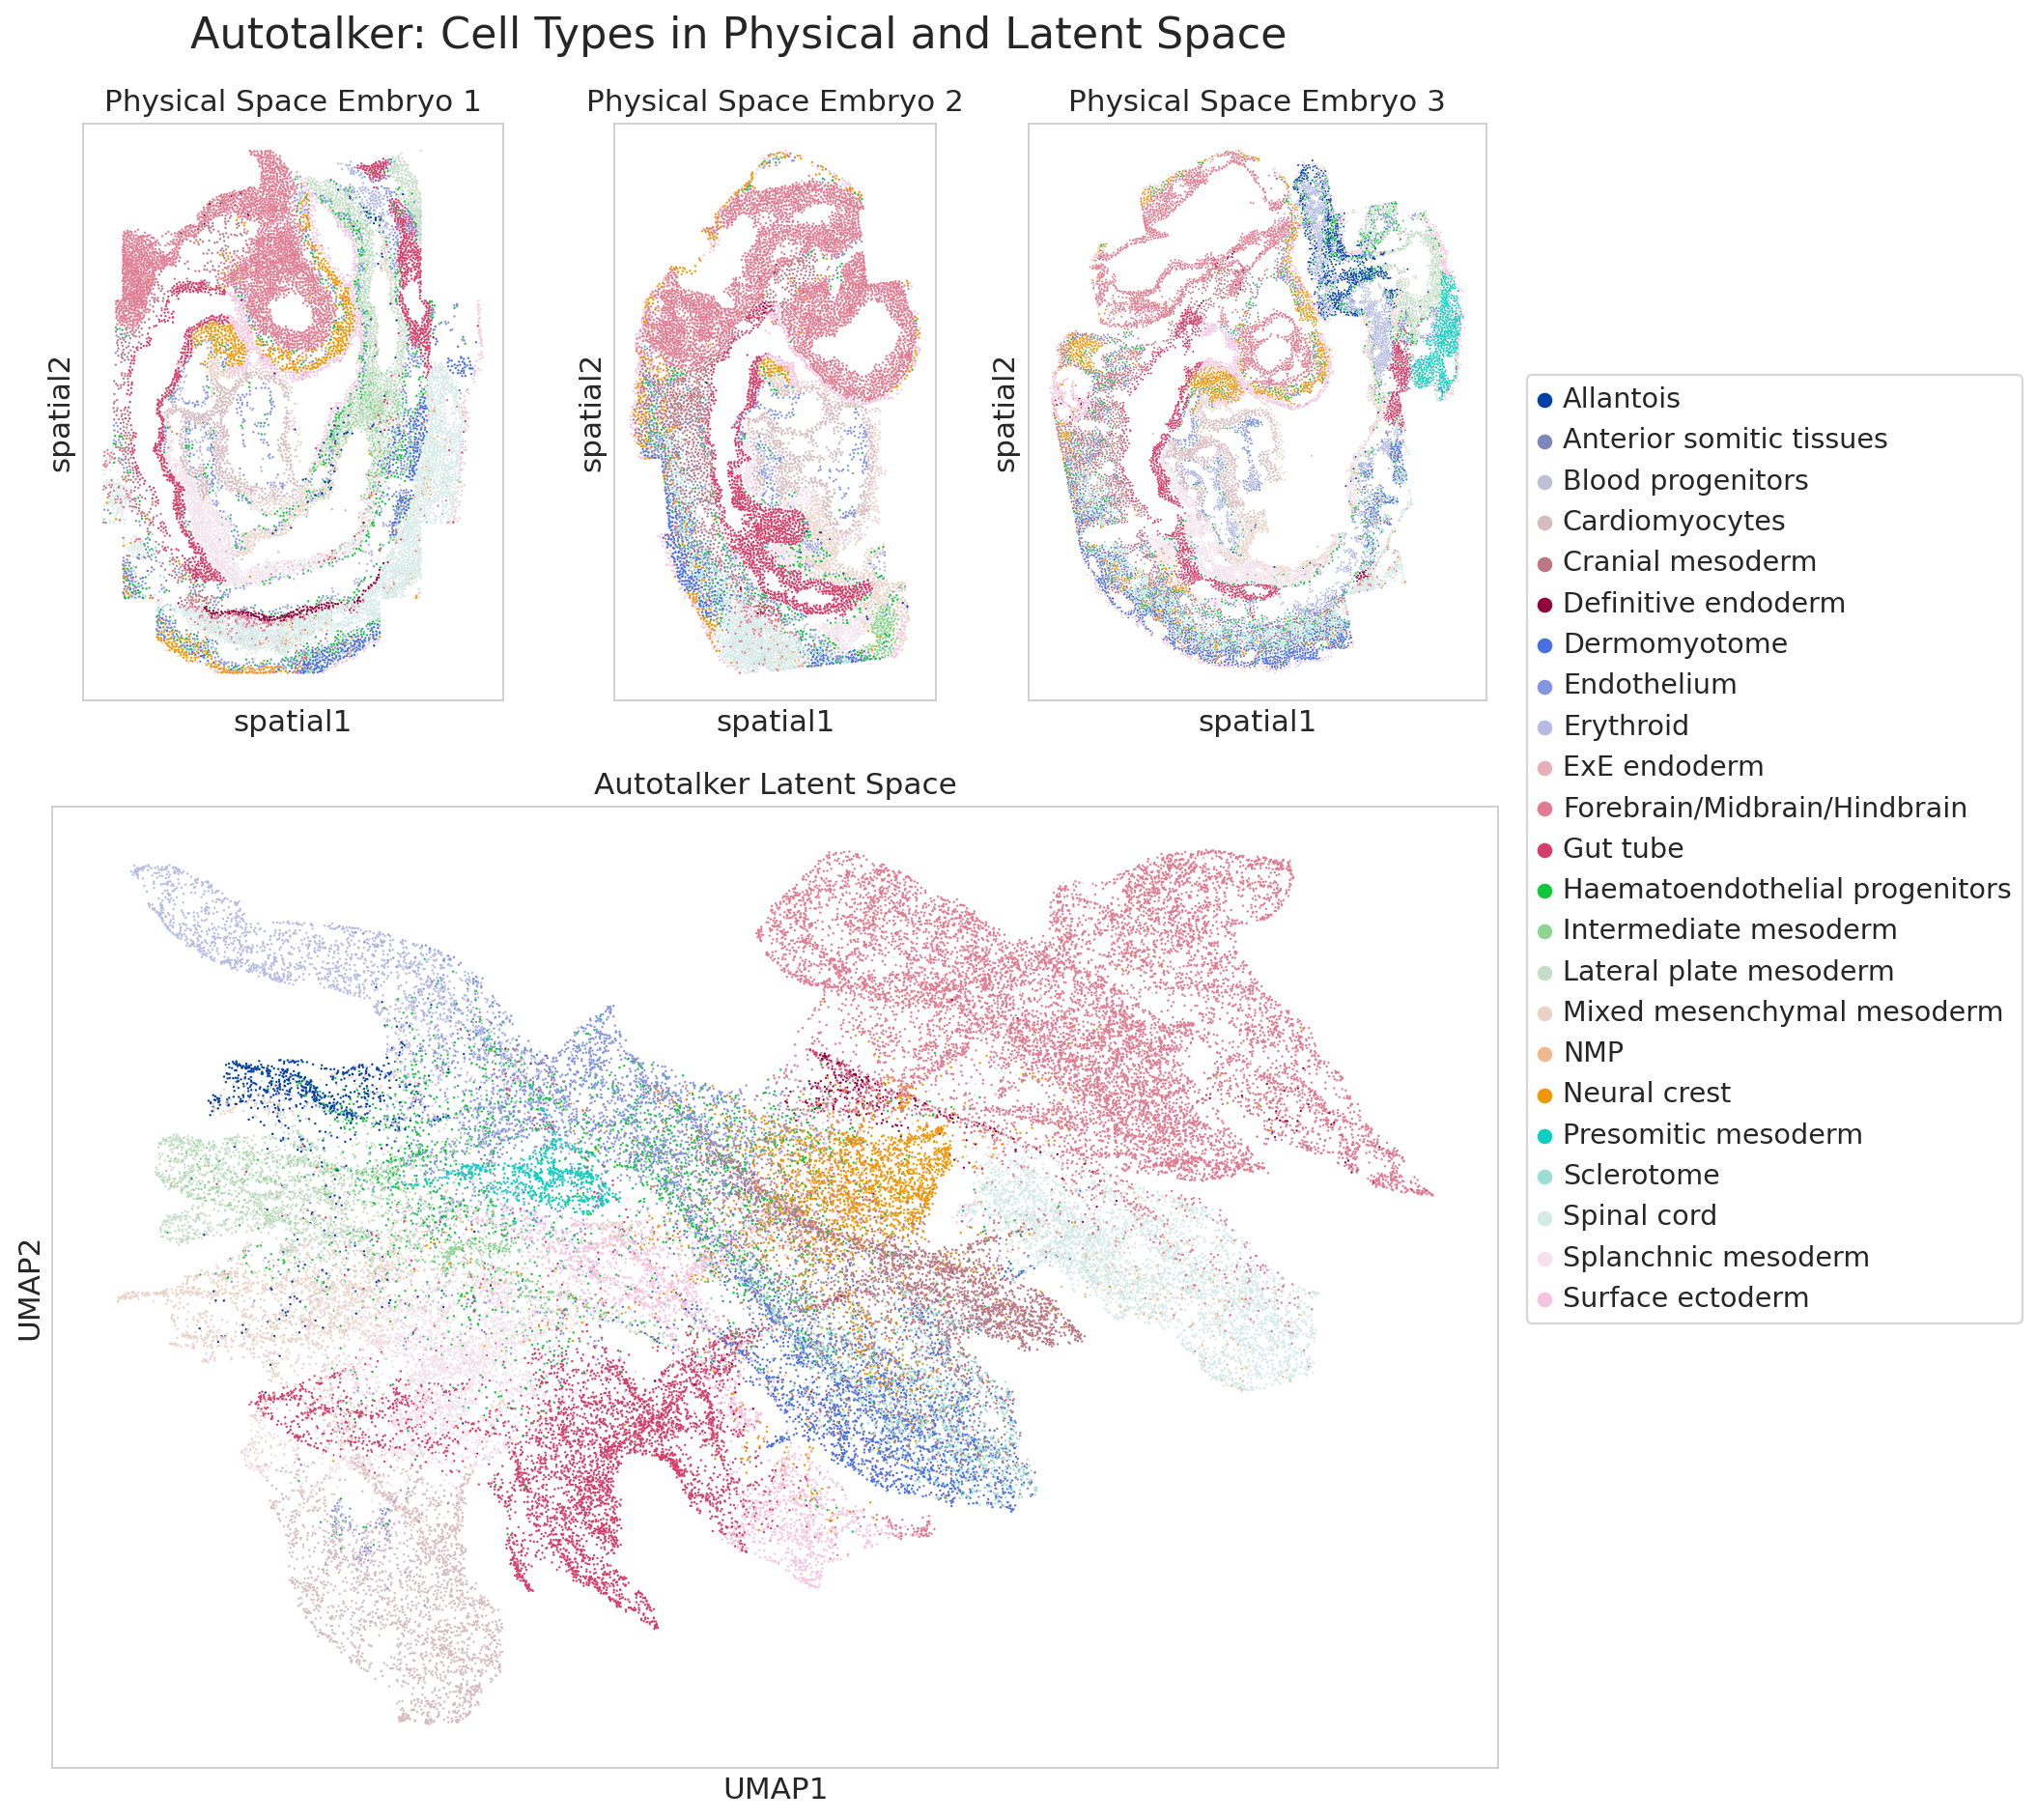

In [60]:
# Create subplot of cell-type annotations in physical and latent space
fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t="Autotalker: Cell Types in Physical and Latent Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec = gridspec.GridSpec(ncols=1,
                         nrows=2,
                         width_ratios=[1],
                         height_ratios=[1, 5])
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(spec[1])
sc.pl.spatial(adata=model.adata[model.adata.obs["sample"] == "embryo1"],
              color=[cell_type_key],
              spot_size=0.03,
              title="Physical Space Embryo 1",
              legend_loc=None,
              ax=ax1,
              show=False)
sc.pl.spatial(adata=model.adata[model.adata.obs["sample"] == "embryo2"],
              color=[cell_type_key],
              spot_size=0.03,
              title="Physical Space Embryo 2",
              legend_loc=None,
              ax=ax2,
              show=False)
sc.pl.spatial(adata=model.adata[model.adata.obs["sample"] == "embryo3"],
              color=[cell_type_key],
              spot_size=0.03,
              title="Physical Space Embryo 3",
              legend_loc=None,
              ax=ax3,
              show=False)
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           size=240000/len(model.adata),
           title="Autotalker Latent Space",
           ax=ax4,
           show=False)

# Create and position shared legend
handles, labels = ax4.get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.25, 0.8))
ax4.get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0., hspace=0.85)
fig.savefig(f"{figure_folder_path}/cell_types_physical_latent_space.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

### 4.2 Latent Leiden Clusters in Latent and Physical Space

In [61]:
# Compute latent Leiden clustering
resolution = 0.3

sc.tl.leiden(adata=model.adata,
             resolution=resolution,
             random_state=random_seed,
             key_added=f"latent_leiden_{str(resolution)}",
             adjacency=model.adata.obsp[f"{latent_key}_connectivities"])

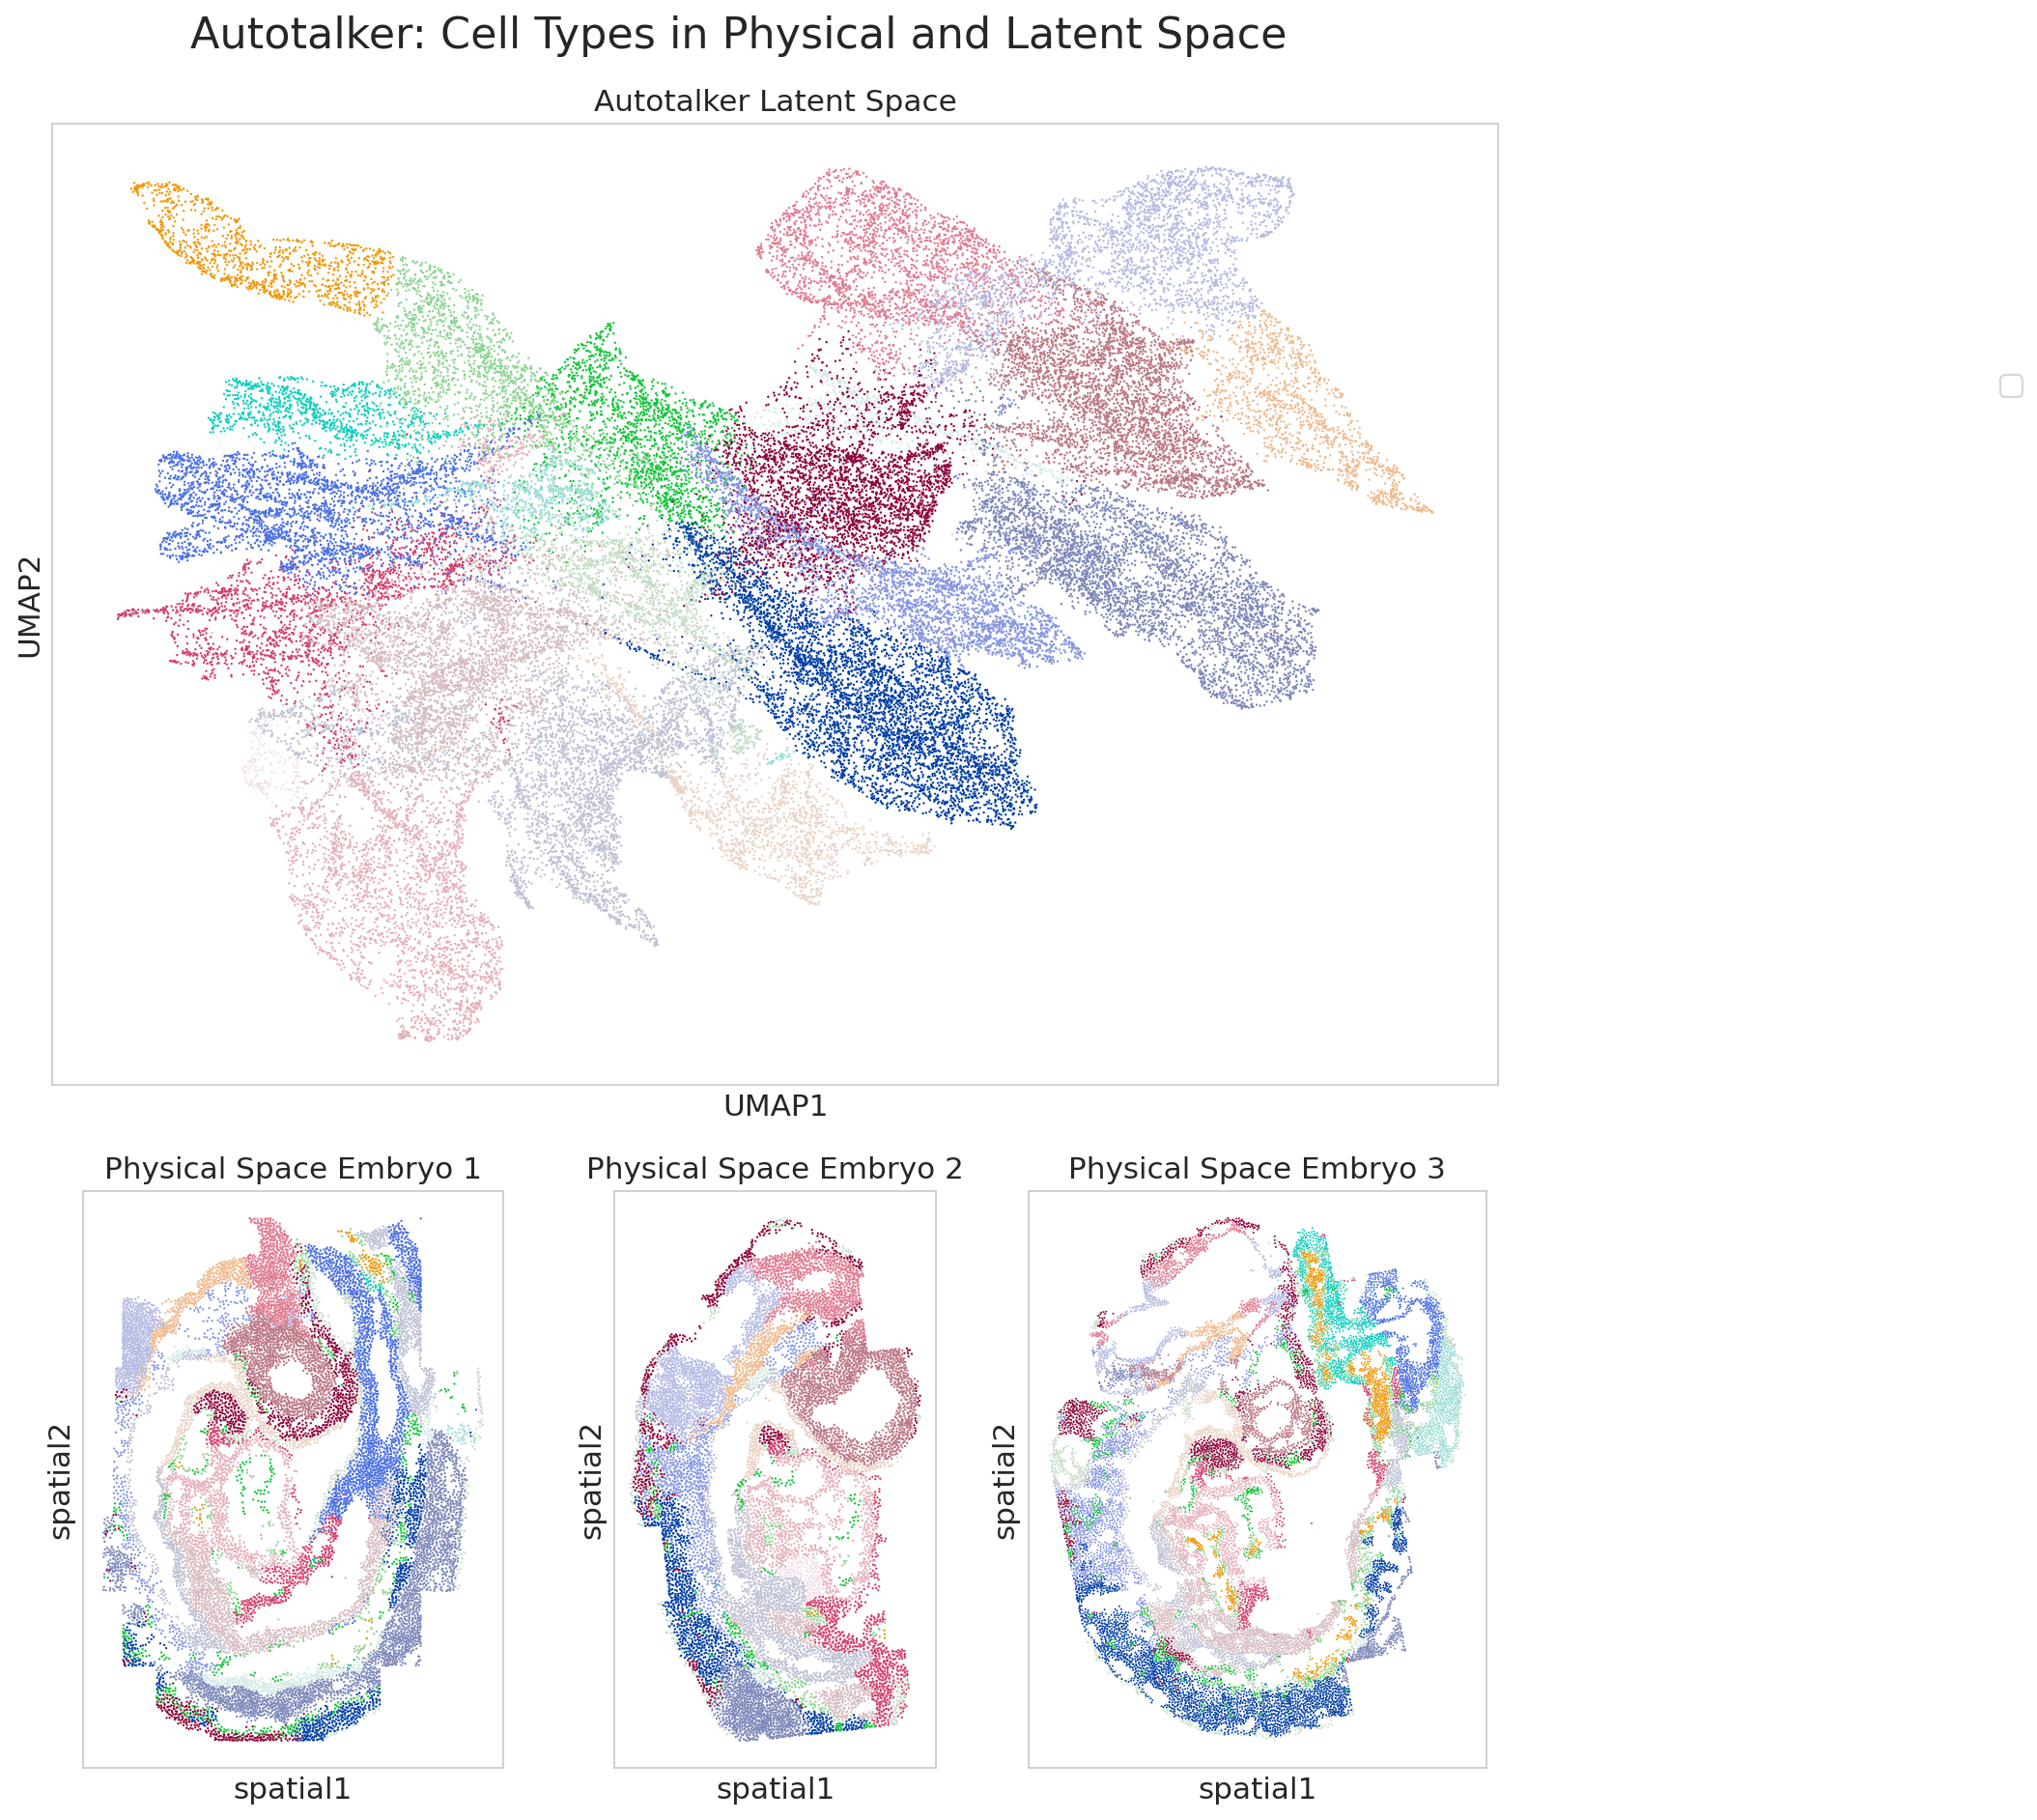

In [64]:
# Create subplot of cell-type annotations in physical and latent space
fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t="Autotalker: Cell Types in Physical and Latent Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec = gridspec.GridSpec(ncols=1,
                         nrows=2,
                         width_ratios=[1],
                         height_ratios=[5, 1])
ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(2, 3, 4)
ax3 = fig.add_subplot(2, 3, 5)
ax4 = fig.add_subplot(2, 3, 6)
sc.pl.umap(adata=model.adata,
           color=[f"latent_leiden_{str(resolution)}"],
           size=240000/len(model.adata),
           title="Autotalker Latent Space",
           ax=ax1,
           show=False)
sc.pl.spatial(adata=model.adata[model.adata.obs["sample"] == "embryo1"],
              color=[f"latent_leiden_{str(resolution)}"],
              spot_size=0.03,
              title="Physical Space Embryo 1",
              legend_loc=None,
              ax=ax2,
              show=False)
sc.pl.spatial(adata=model.adata[model.adata.obs["sample"] == "embryo2"],
              color=[f"latent_leiden_{str(resolution)}"],
              spot_size=0.03,
              title="Physical Space Embryo 2",
              legend_loc=None,
              ax=ax3,
              show=False)
sc.pl.spatial(adata=model.adata[model.adata.obs["sample"] == "embryo3"],
              color=[f"latent_leiden_{str(resolution)}"],
              spot_size=0.03,
              title="Physical Space Embryo 3",
              legend_loc=None,
              ax=ax4,
              show=False)

# Create and position shared legend
handles, labels = ax4.get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.25, 0.8))
ax1.get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0., hspace=0.85)
fig.savefig(f"{figure_folder_path}/latent_leiden_clusters_latent_physical_space.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

### 4.3 GP Enrichments

#### 4.3.1 Cell-type GP Enrichments

In [ ]:
differential_gp_scores_key = "autotalker_cell_type_differential_gp_scores"
n_top_up_gps = 10
n_top_down_gps = 10

##### 4.3.1.1 Explore All GPs Across All Categories

In [ ]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                                      adata=model.adata,
                                                      selected_gps=None, # ["BMP7_ligand_targetgenes_GP", "CD24_ligand_targetgenes_GP"],
                                                      selected_cats=None, # ["Cardiomyocytes", "Presomitic mesoderm"]
                                                      gp_scores_weight_normalization=True,
                                                      comparison_cats="rest",
                                                      n_sample=10000,
                                                      key_added=differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

In [ ]:
# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

In [ ]:
# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

In [ ]:
fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title="Differential GP Scores Per Cell-type",
                    return_fig=True)

# Save and display plot
fig.savefig(f"{figure_folder_path}/differential_gp_scores_per_cell_type_all_categories.png")
plt.show()

In [ ]:
top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()
top_genes = []

for gp in top_gps:
    top_genes.append(
        model.compute_gp_gene_importances(selected_gp=gp)["gene"][0])

In [ ]:
# Plot selected gene program latent scores
fig, axs = plt.subplots(nrows=n_top_up_gps+n_top_down_gps, ncols=3, figsize=(18, 4*len(top_gps)))
title = fig.suptitle(t="Differential GP Scores, Corresponding Cell-Types and Most Important GP Genes in Latent Space",
                     x=0.55,
                     y=0.96,
                     fontsize=20)
for i in range(len(top_gps)):
    sc.pl.umap(model.adata, color=top_gps[i], color_map="magma", ax=axs[i, 0], show=False)
    sc.pl.umap(model.adata,
               color=[cell_type_key],
               color_map="magma",
               groups=top_cats[i],
               ax=axs[i, 1],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    sc.pl.umap(model.adata,
               color=top_genes[i],
               color_map="binary",
               ax=axs[i, 2],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    
# Save and display plot
fig.savefig(f"{figure_folder_path}/cell_type_gp_scores_cell_types_most_important_genes_all_categories.png",
            bbox_extra_artists=(title,),
            bbox_inches="tight")
plt.show()

##### 4.3.1.2 Explore All GPs Across Specific Categories

In [ ]:
selected_cats = ["Erythroid", "Cardiomyocytes"]

In [ ]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                                      adata=model.adata,
                                                      selected_gps=None,
                                                      selected_cats=selected_cats,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats="rest",
                                                      n_sample=1000,
                                                      key_added=differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

In [ ]:
# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

In [ ]:
# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

In [ ]:
fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title="Differential GP Scores Per Cell-type",
                    return_fig=True)

# Save and display plot
fig.savefig(f"{figure_path}/differential_gp_scores_per_cell_type_specific_categories.png")
plt.show()

In [ ]:
top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()
top_genes = []

for gp in top_gps:
    top_genes.append(
        model.compute_gp_gene_importances(selected_gp=gp)["gene"][0])

In [ ]:
# Plot selected gene program latent scores
fig, axs = plt.subplots(nrows=n_top_up_gps+n_top_down_gps, ncols=3, figsize=(18, 4*len(top_gps)))
title = fig.suptitle(t="Differential GP Scores, Corresponding Cell-Types and Most Important GP Genes in Latent Space",
                     x=0.55,
                     y=0.96,
                     fontsize=20)
for i in range(len(top_gps)):
    sc.pl.umap(model.adata, color=top_gps[i], color_map="magma", ax=axs[i, 0], show=False)
    sc.pl.umap(model.adata,
               color=[cell_type_key],
               color_map="magma",
               groups=top_cats[i],
               ax=axs[i, 1],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    sc.pl.umap(model.adata,
               color=top_genes[i],
               color_map="binary",
               ax=axs[i, 2],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    
# Save and display plot
fig.savefig(f"{figure_path}/cell_type_gp_scores_cell_types_most_important_genes_specific_categories.png",
            bbox_extra_artists=(title,),
            bbox_inches="tight")
plt.show()

##### 4.3.1.3 Explore Specific GPs

In [ ]:
selected_gps = ["BMP7_ligand_targetgenes_GP", "EPOR_ligand_receptor_GP"]

In [ ]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                                      adata=model.adata,
                                                      selected_gps=selected_gps,
                                                      selected_cats=None,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats="rest",
                                                      n_sample=1000,
                                                      key_added=differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

In [ ]:
# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

In [ ]:
# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

In [ ]:
fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title="Differential GP Scores Per Cell-type",
                    return_fig=True)

# Save and display plot
fig.savefig(f"{figure_path}/differential_gp_scores_per_cell_type_specific_gps.png")
plt.show()

In [ ]:
top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()
top_genes = []

for gp in top_gps:
    top_genes.append(
        model.compute_gp_gene_importances(selected_gp=gp)["gene"][0])

In [ ]:
# Plot selected gene program latent scores
fig, axs = plt.subplots(nrows=n_top_up_gps+n_top_down_gps, ncols=3, figsize=(18, 4*len(top_gps)))
title = fig.suptitle(t="Differential GP Scores, Corresponding Cell-Types and Most Important GP Genes in Latent Space",
                     x=0.55,
                     y=0.96,
                     fontsize=20)
for i in range(len(top_gps)):
    sc.pl.umap(model.adata, color=top_gps[i], color_map="magma", ax=axs[i, 0], show=False)
    sc.pl.umap(model.adata,
               color=[cell_type_key],
               color_map="magma",
               groups=top_cats[i],
               ax=axs[i, 1],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    sc.pl.umap(model.adata,
               color=top_genes[i],
               color_map="binary",
               ax=axs[i, 2],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    
# Save and display plot
fig.savefig(f"{figure_path}/cell_type_gp_scores_cell_types_most_important_genes_specific_gps.png",
            bbox_extra_artists=(title,),
            bbox_inches="tight")
plt.show()

#### 4.3.2 Spatial GP Enrichments

Same analysis can be done with spatial cluster labels instead of cell-types.

#### 4.3.3 GP Gene Importances

In [ ]:
selected_gp = ["BMP7_ligand_targetgenes_GP"]

In [ ]:
gene_importances_df = model.compute_gp_gene_importances(
    selected_gp="BMP7_ligand_receptor_GP",
    adata=None)

display(gene_importances_df)

In [ ]:
genes = list(gene_importances_df["gene"])

for gene in genes:
    sc.pl.umap(model.adata,
               color=gene,
               color_map="binary",
               legend_loc="on data",
               na_in_legend=False)

## 5. Learn De-Novo CCI GPs

### 5.1 Initialize, Train & Save Model

In [ ]:
model = Autotalker.load(dir_path=f"{model_artifacts_path}/autotalker_combined_gps_{current_timestamp}",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        n_addon_gps=10,
                        gp_names_key=gp_names_key,
                        freeze_non_addon_weights=True)

In [ ]:
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_l1_addon=lambda_l1_addon)

In [ ]:
model.save(dir_path=f"{model_artifacts_path}/autotalker_combined_denovo_gps_{current_timestamp}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

Same analysis can be repeated with de-novo gene programs.